In [2]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot stying
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 
from keras.layers import LSTM

# sklearn functionalities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

Using TensorFlow backend.


# Artificial Neural Networks for Time Series Forecasting

<strong>Artificial neural networks (ANNs)</strong> are computing systems inspired by the biological neural networks that constitute bilological brains. Such systems learn (progressively improve performance) to do tasks by considering examples, generally without task-specific programming (if-then clauses).

An ANN is based on a collection of connected units called <strong>Perceptrons</strong>, a linear classifier analogous to neurons in a biological brain. Each connection (synapse) between neurons can transmit a signal to another neuron. The receiving (postsynaptic) neuron can process the signal(s) and then signal downstream neurons connected to it.

Neurons may have state, generally represented by real numbers, typically between 0 and 1. Neurons and synapses may also have a weight that varies as learning proceeds, which can increase or decrease the strength of the signal that it sends downstream. Further, they may have a threshold such that only if the aggregate signal is below (or above) that level is the downstream signal sent. - <a href="https://en.wikipedia.org/wiki/Artificial_neural_network">Wikipedia</a>




https://www.youtube.com/watch?v=MVyauNNinC0

## Neural Network Basics

An ANN takes an input matrix $X$ applies a weights $W$ on the way through the network from input layer to the output layer to estimate some output $y$. This estimation process is knwon as <strong>Forward Propagation</strong>. The estimate $\hat{y}$ is compared to the actual observation $y$ using a <strong>Cost Function</strong> $E$ which computes the sum of squared errors. 

If the cost function is minimized for all weight parameters the neural network learns the most effective representation of the data $\hat{y}$ that leads the desired result $y$. That is, in every iteration the weights in the network are being adjusted in accordance to their contribution to the total error in the estimation. This process is called <strong> Back Propagation</strong>. Since $W$ is a vector


## A Supervised Learning Task

Time series prediction problems are inherently different from supervised learning problems in that obervastions posses a timely ordering and no observeable input. Thus, the time series prediction problem has to be converted into a regression problem.

A supervised learing problem requires data of the form $(y, X)$ where $y$ is the observeable output and $X$ is a matrix of input data which is assumed to cause the observed output. Since the output variable $y$ is assumed to be continuous this problem is called a supervised regression problem.

In [3]:
np.random.seed(7)

In [18]:
df = pd.read_csv('./data/passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values

# using keras often requires the data type float32
data = data.astype('float32')

# slice the data
train = data[0:120, :]
test = data[120:, :]

print(len(train), len(test))

120 24


In [19]:
data

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.],
       [ 104.],
       [ 118.],
       [ 115.],
       [ 126.],
       [ 141.],
       [ 135.],
       [ 125.],
       [ 149.],
       [ 170.],
       [ 170.],
       [ 158.],
       [ 133.],
       [ 114.],
       [ 140.],
       [ 145.],
       [ 150.],
       [ 178.],
       [ 163.],
       [ 172.],
       [ 178.],
       [ 199.],
       [ 199.],
       [ 184.],
       [ 162.],
       [ 146.],
       [ 166.],
       [ 171.],
       [ 180.],
       [ 193.],
       [ 181.],
       [ 183.],
       [ 218.],
       [ 230.],
       [ 242.],
       [ 209.],
       [ 191.],
       [ 172.],
       [ 194.],
       [ 196.],
       [ 196.],
       [ 236.],
       [ 235.],
       [ 229.],
       [ 243.],
       [ 264.],
       [ 272.],
       [ 237.],
       [ 211.],
       [ 180.],
       [ 201.],
       [ 204.],
       [ 188.],
       [

The <code>create_data</code> function will be used to transform the time series into a regression problem. The <code>lags</code> argument takes an integer which corresponds the the number of previous time steps to use as input variables to predict the next time period. The default value is one but will be changed in a next iteration.

With the default setting a data set will be created where $X$ is the number of passengers at time $t$ and $y$ is the number of passengers at time $t+1$.

In [12]:
len(train)

120

In [57]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [58]:
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

In [59]:
y_train

array([ 118.,  132.,  129.,  121.,  135.,  148.,  148.,  136.,  119.,
        104.,  118.,  115.,  126.,  141.,  135.,  125.,  149.,  170.,
        170.,  158.,  133.,  114.,  140.,  145.,  150.,  178.,  163.,
        172.,  178.,  199.,  199.,  184.,  162.,  146.,  166.,  171.,
        180.,  193.,  181.,  183.,  218.,  230.,  242.,  209.,  191.,
        172.,  194.,  196.,  196.,  236.,  235.,  229.,  243.,  264.,
        272.,  237.,  211.,  180.,  201.,  204.,  188.,  235.,  227.,
        234.,  264.,  302.,  293.,  259.,  229.,  203.,  229.,  242.,
        233.,  267.,  269.,  270.,  315.,  364.,  347.,  312.,  274.,
        237.,  278.,  284.,  277.,  317.,  313.,  318.,  374.,  413.,
        405.,  355.,  306.,  271.,  306.,  315.,  301.,  356.,  348.,
        355.,  422.,  465.,  467.,  404.,  347.,  305.,  336.,  340.,
        318.,  362.,  348.,  363.,  435.,  491.,  505.,  404.,  359.,  310.], dtype=float32)

In [60]:
X_train

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.],
       [ 104.],
       [ 118.],
       [ 115.],
       [ 126.],
       [ 141.],
       [ 135.],
       [ 125.],
       [ 149.],
       [ 170.],
       [ 170.],
       [ 158.],
       [ 133.],
       [ 114.],
       [ 140.],
       [ 145.],
       [ 150.],
       [ 178.],
       [ 163.],
       [ 172.],
       [ 178.],
       [ 199.],
       [ 199.],
       [ 184.],
       [ 162.],
       [ 146.],
       [ 166.],
       [ 171.],
       [ 180.],
       [ 193.],
       [ 181.],
       [ 183.],
       [ 218.],
       [ 230.],
       [ 242.],
       [ 209.],
       [ 191.],
       [ 172.],
       [ 194.],
       [ 196.],
       [ 196.],
       [ 236.],
       [ 235.],
       [ 229.],
       [ 243.],
       [ 264.],
       [ 272.],
       [ 237.],
       [ 211.],
       [ 180.],
       [ 201.],
       [ 204.],
       [ 188.],
       [

In [61]:
y_train

array([ 118.,  132.,  129.,  121.,  135.,  148.,  148.,  136.,  119.,
        104.,  118.,  115.,  126.,  141.,  135.,  125.,  149.,  170.,
        170.,  158.,  133.,  114.,  140.,  145.,  150.,  178.,  163.,
        172.,  178.,  199.,  199.,  184.,  162.,  146.,  166.,  171.,
        180.,  193.,  181.,  183.,  218.,  230.,  242.,  209.,  191.,
        172.,  194.,  196.,  196.,  236.,  235.,  229.,  243.,  264.,
        272.,  237.,  211.,  180.,  201.,  204.,  188.,  235.,  227.,
        234.,  264.,  302.,  293.,  259.,  229.,  203.,  229.,  242.,
        233.,  267.,  269.,  270.,  315.,  364.,  347.,  312.,  274.,
        237.,  278.,  284.,  277.,  317.,  313.,  318.,  374.,  413.,
        405.,  355.,  306.,  271.,  306.,  315.,  301.,  356.,  348.,
        355.,  422.,  465.,  467.,  404.,  347.,  305.,  336.,  340.,
        318.,  362.,  348.,  363.,  435.,  491.,  505.,  404.,  359.,  310.], dtype=float32)

The data set now has the following form
<pre>
X       y
112     118
118     132
132     129
129     121
121     135
</pre>
That is, the function has successfully shifted the data for one time step and saved this new shifted series to an array.

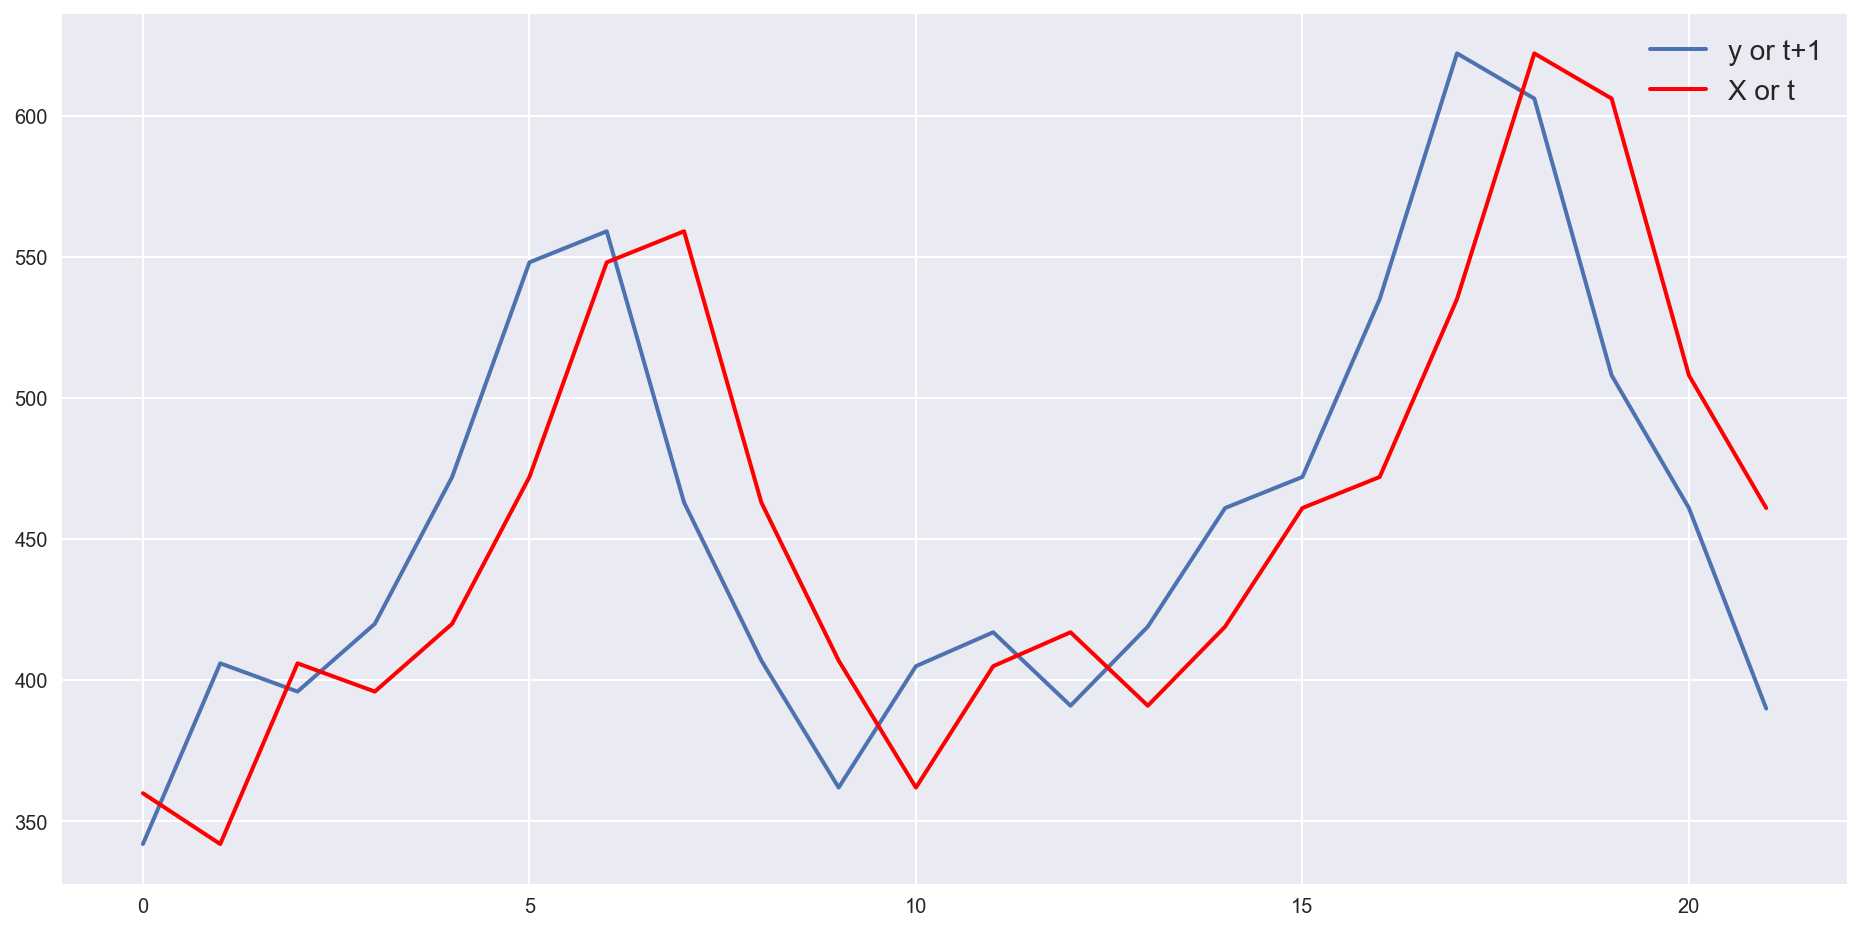

In [62]:
# plot the created data
plt.plot(y_test, label='y or t+1')
plt.plot(X_test, label='X or t', color='red')
plt.legend(loc='best')
plt.show()

## Multilayer Perceptron Network

As previously, the data is sliced up into a <code>train</code> and <code>test</code> set to evaluate the performance of a two-year-ahead forecast.

The first simple network will have one input (size of the <code>lags</code> variable), one hidden layer with 8 neurons and an output layer. The model is fitted using the MSE criterion and rectified linear units as activation function

In [63]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(8, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
0s - loss: 134157.8153
Epoch 2/200
0s - loss: 102860.0702
Epoch 3/200
0s - loss: 80908.3925
Epoch 4/200
0s - loss: 64931.1135
Epoch 5/200
0s - loss: 50436.3172
Epoch 6/200
0s - loss: 37299.7504
Epoch 7/200
0s - loss: 25868.3224
Epoch 8/200
0s - loss: 16474.2203
Epoch 9/200
0s - loss: 9673.9963
Epoch 10/200
0s - loss: 5273.5394
Epoch 11/200
0s - loss: 2801.2421
Epoch 12/200
0s - loss: 1587.9615
Epoch 13/200
0s - loss: 1095.3618
Epoch 14/200
0s - loss: 911.8399
Epoch 15/200
0s - loss: 847.7126
Epoch 16/200
0s - loss: 831.7836
Epoch 17/200
0s - loss: 829.0933
Epoch 18/200
0s - loss: 827.4099
Epoch 19/200
0s - loss: 825.4606
Epoch 20/200
0s - loss: 827.3420
Epoch 21/200
0s - loss: 828.4573
Epoch 22/200
0s - loss: 828.0145
Epoch 23/200
0s - loss: 830.3777
Epoch 24/200
0s - loss: 828.4311
Epoch 25/200
0s - loss: 827.9702
Epoch 26/200
0s - loss: 829.9997
Epoch 27/200
0s - loss: 826.0334
Epoch 28/200
0s - loss: 825.7769
Epoch 29/200
0s - loss: 833.6519
Epoch 30/200
0s - loss: 829.2

In [64]:
# estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 817.35 MSE (28.59 RMSE)
Test Score: 2801.79 MSE (52.93 RMSE)


In [65]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

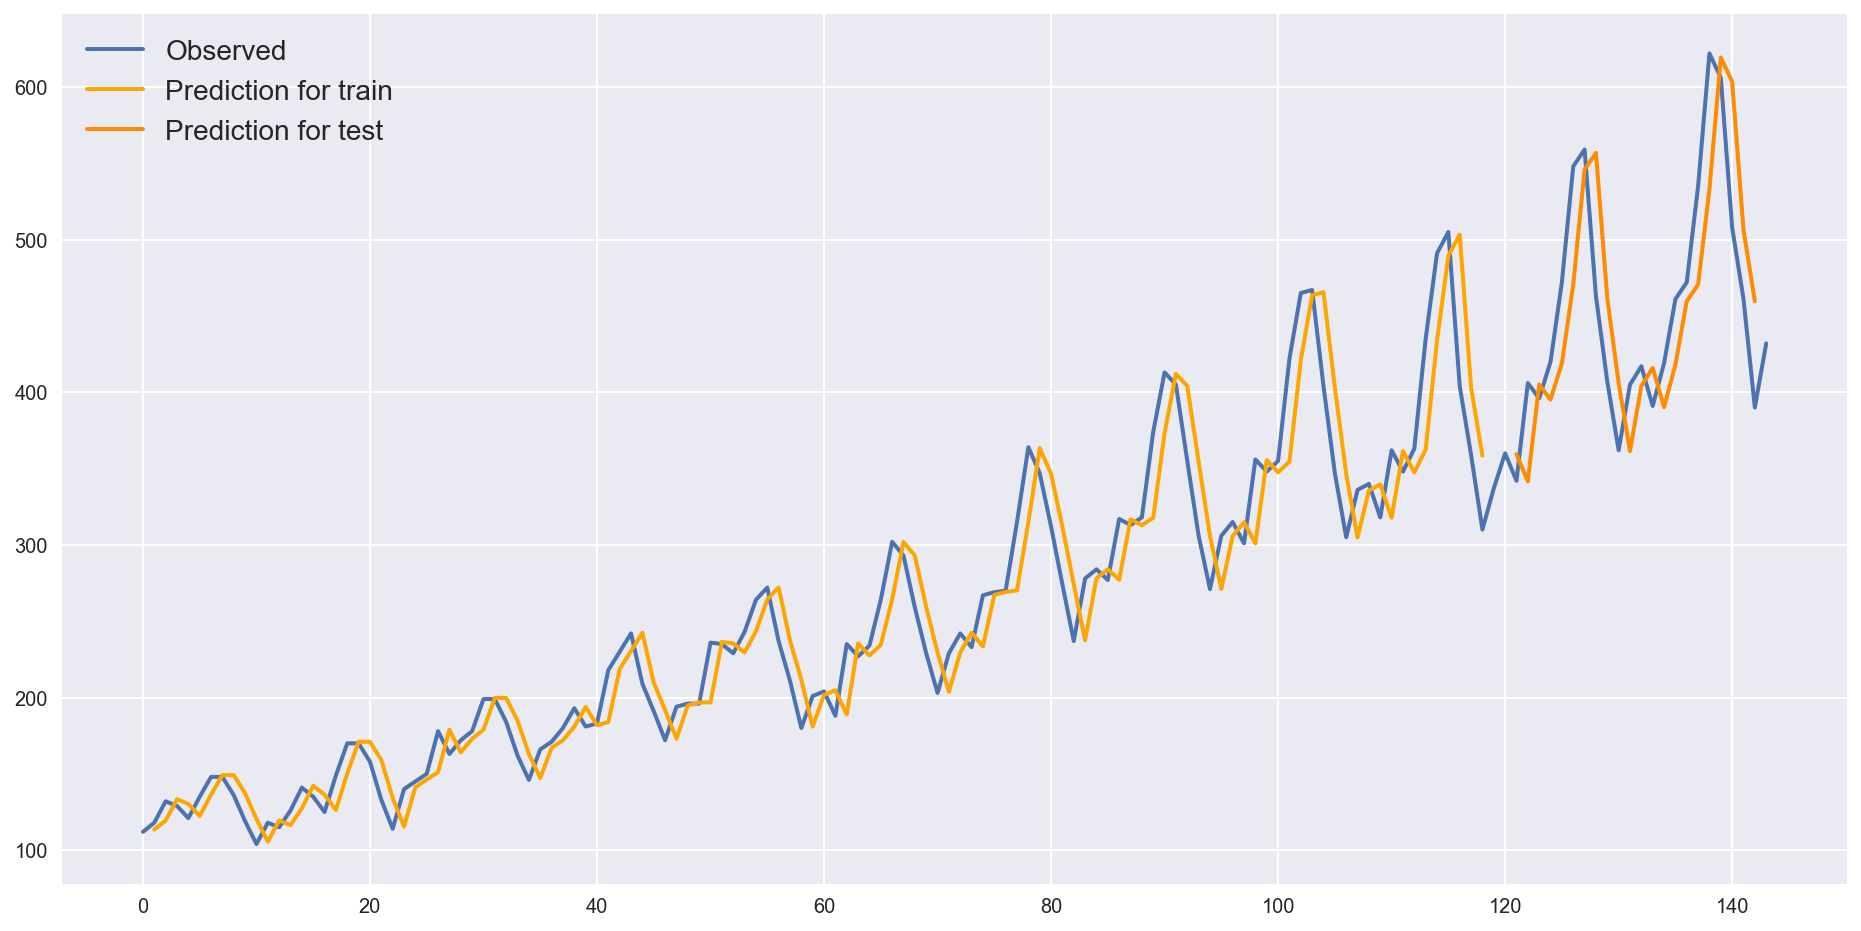

In [67]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-1, :] = test_predict

# plot baseline and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

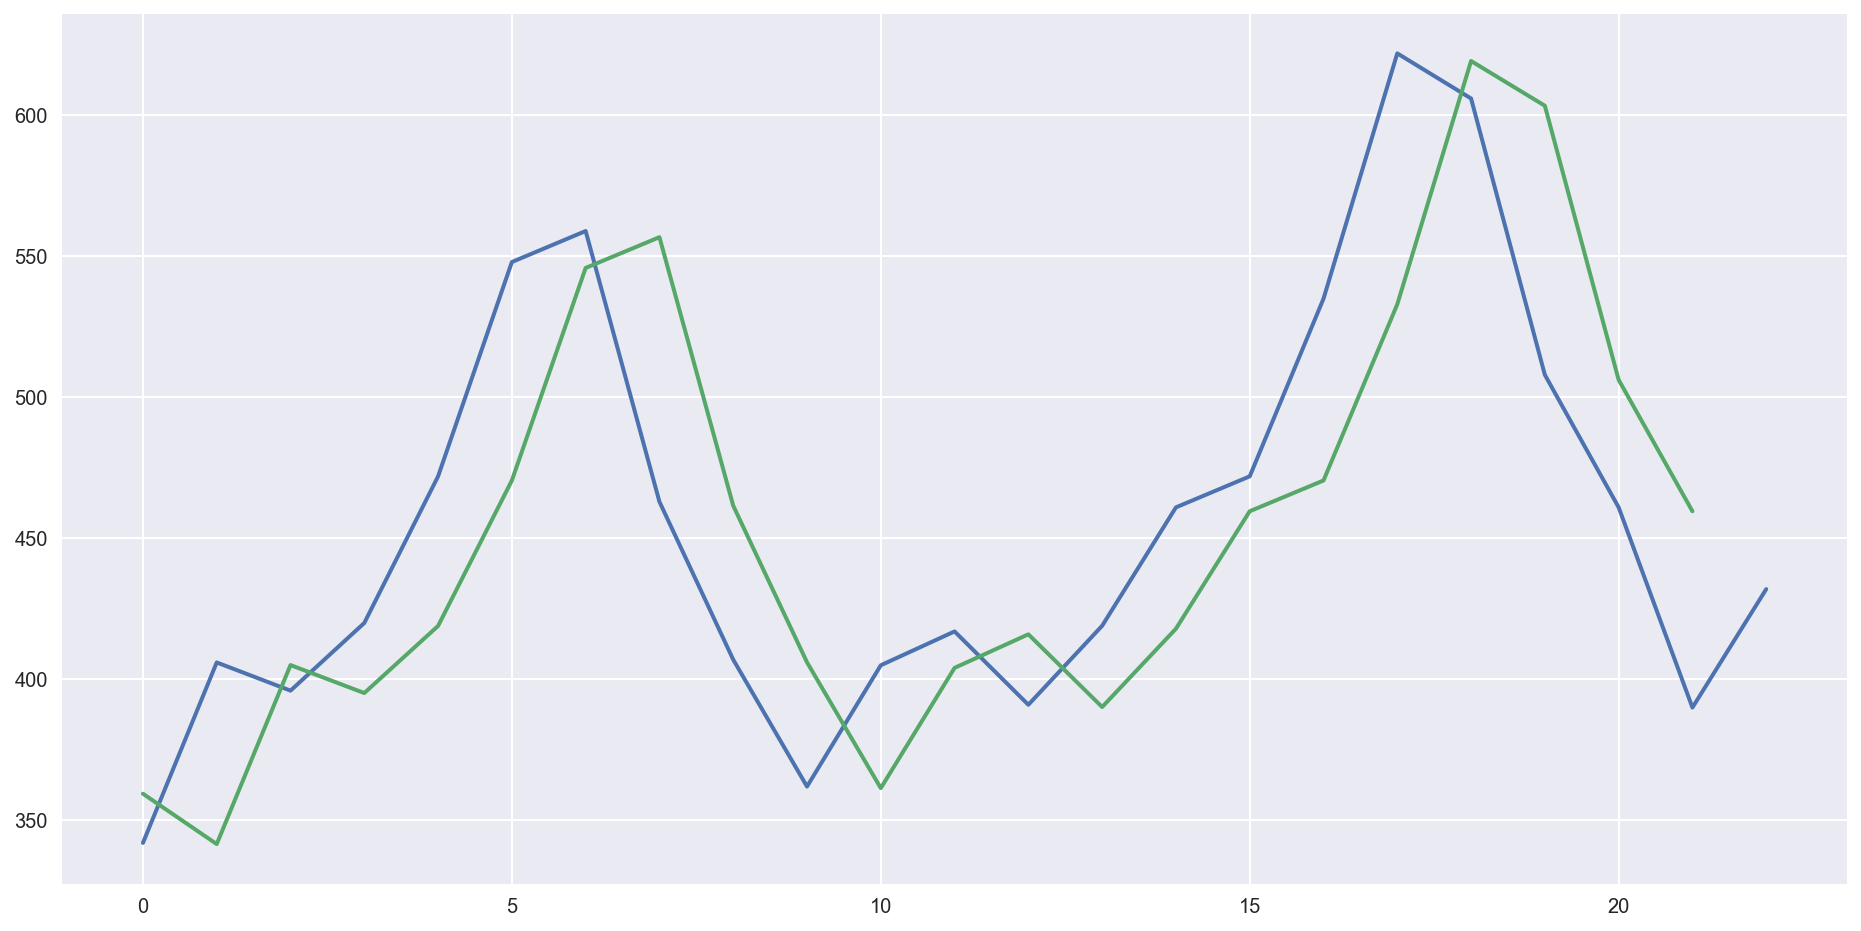

In [70]:
plt.plot(np.array(df['n_passengers'][121:]))
#plt.plot(y_test)
plt.plot(test_predict)
plt.show()

In [71]:
mse = ((y_test - test_predict) ** 2).mean()
print(mse)
print(math.sqrt(mse))

11438.1
106.94923408736969


Since the neural network has only been fed by the last observation, it did not have much choice but to learn to apply observation $t$ for the prediction of $t+1$.

## Multilayer perceptron with window

In [72]:
# reshape dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

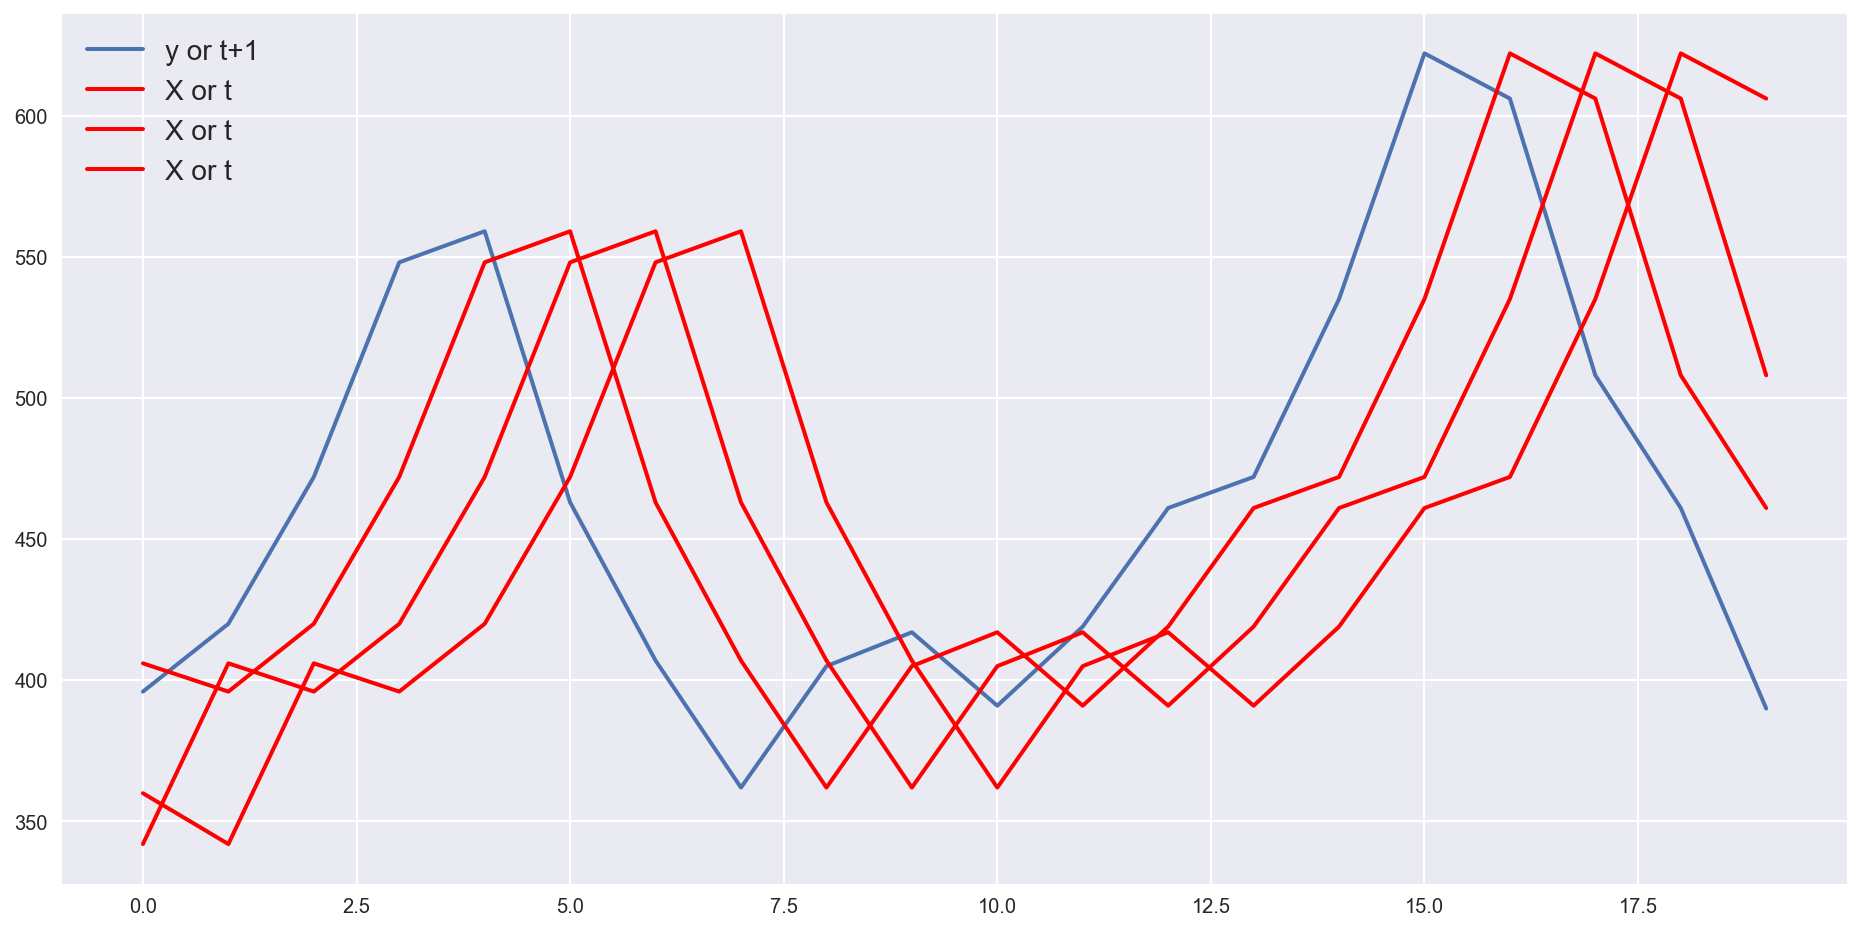

In [73]:
# plot the created data
plt.plot(y_test, label='y or t+1')
plt.plot(X_test, label='X or t', color='red')
plt.legend(loc='best')
plt.show()

In [74]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(12, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
0s - loss: 37683.8386
Epoch 2/400
0s - loss: 10139.8703
Epoch 3/400
0s - loss: 1708.8657
Epoch 4/400
0s - loss: 1477.1153
Epoch 5/400
0s - loss: 1452.5538
Epoch 6/400
0s - loss: 1570.2705
Epoch 7/400
0s - loss: 1424.3184
Epoch 8/400
0s - loss: 1453.7033
Epoch 9/400
0s - loss: 1475.2358
Epoch 10/400
0s - loss: 1423.7046
Epoch 11/400
0s - loss: 1464.3343
Epoch 12/400
0s - loss: 1405.4516
Epoch 13/400
0s - loss: 1395.0585
Epoch 14/400
0s - loss: 1384.4273
Epoch 15/400
0s - loss: 1365.8658
Epoch 16/400
0s - loss: 1387.5509
Epoch 17/400
0s - loss: 1360.1794
Epoch 18/400
0s - loss: 1361.8452
Epoch 19/400
0s - loss: 1335.4110
Epoch 20/400
0s - loss: 1326.8666
Epoch 21/400
0s - loss: 1347.2258
Epoch 22/400
0s - loss: 1339.1863
Epoch 23/400
0s - loss: 1318.8708
Epoch 24/400
0s - loss: 1310.6284
Epoch 25/400
0s - loss: 1309.1134
Epoch 26/400
0s - loss: 1289.0065
Epoch 27/400
0s - loss: 1280.6503
Epoch 28/400
0s - loss: 1304.2103
Epoch 29/400
0s - loss: 1262.7060
Epoch 30/400
0s - los

0s - loss: 845.2389
Epoch 244/400
0s - loss: 814.5013
Epoch 245/400
0s - loss: 847.7988
Epoch 246/400
0s - loss: 781.6858
Epoch 247/400
0s - loss: 854.5599
Epoch 248/400
0s - loss: 874.6229
Epoch 249/400
0s - loss: 838.3390
Epoch 250/400
0s - loss: 842.0120
Epoch 251/400
0s - loss: 817.2935
Epoch 252/400
0s - loss: 820.2367
Epoch 253/400
0s - loss: 826.8674
Epoch 254/400
0s - loss: 836.3181
Epoch 255/400
0s - loss: 814.5560
Epoch 256/400
0s - loss: 814.7500
Epoch 257/400
0s - loss: 804.5844
Epoch 258/400
0s - loss: 811.6285
Epoch 259/400
0s - loss: 810.3641
Epoch 260/400
0s - loss: 864.8885
Epoch 261/400
0s - loss: 873.8541
Epoch 262/400
0s - loss: 828.6123
Epoch 263/400
0s - loss: 846.3718
Epoch 264/400
0s - loss: 806.9922
Epoch 265/400
0s - loss: 839.7059
Epoch 266/400
0s - loss: 813.6966
Epoch 267/400
0s - loss: 830.0837
Epoch 268/400
0s - loss: 850.1002
Epoch 269/400
0s - loss: 880.9783
Epoch 270/400
0s - loss: 807.9057
Epoch 271/400
0s - loss: 827.8752
Epoch 272/400
0s - loss: 816

In [75]:
# Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 767.97 MSE (27.71 RMSE)
Test Score: 2235.12 MSE (47.28 RMSE)


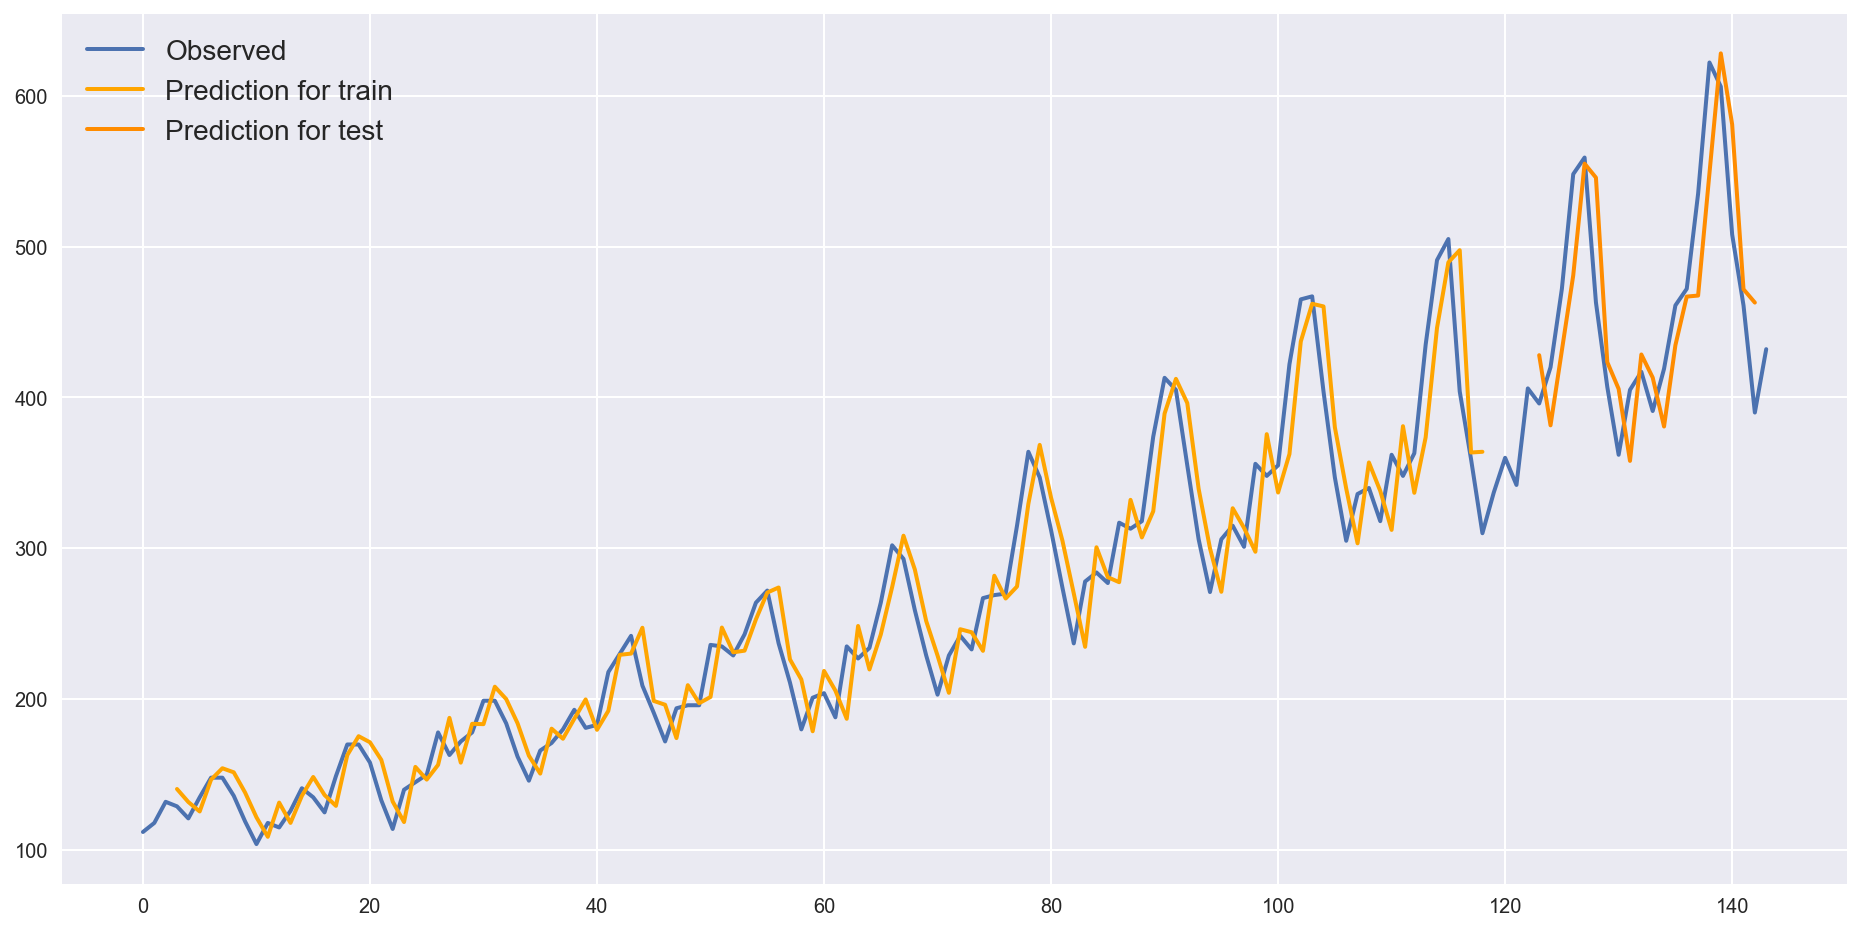

In [23]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

In [76]:
mse = ((y_test - test_predict) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 11251.09 MSE (106.07 RMSE)


# LSTM Recurrent Neural Network

In [53]:
# fix random seed for reproducibility
np.random.seed(1)

# load the dataset
df = pd.read_csv('./data/passengers.csv', sep=';', parse_dates=True, index_col=0)
data = df.values
data = data.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# split into train and test sets
train = dataset[0:120, :]
test = dataset[120:, :]

# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [54]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, lags)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0615
Epoch 2/100
0s - loss: 0.0239
Epoch 3/100
0s - loss: 0.0172
Epoch 4/100
0s - loss: 0.0145
Epoch 5/100
0s - loss: 0.0123
Epoch 6/100
0s - loss: 0.0107
Epoch 7/100
0s - loss: 0.0092
Epoch 8/100
0s - loss: 0.0082
Epoch 9/100
0s - loss: 0.0076
Epoch 10/100
0s - loss: 0.0071
Epoch 11/100
0s - loss: 0.0069
Epoch 12/100
0s - loss: 0.0068
Epoch 13/100
0s - loss: 0.0064
Epoch 14/100
0s - loss: 0.0064
Epoch 15/100
0s - loss: 0.0061
Epoch 16/100
0s - loss: 0.0060
Epoch 17/100
0s - loss: 0.0059
Epoch 18/100
0s - loss: 0.0060
Epoch 19/100
0s - loss: 0.0058
Epoch 20/100
0s - loss: 0.0057
Epoch 21/100
0s - loss: 0.0056
Epoch 22/100
0s - loss: 0.0054
Epoch 23/100
0s - loss: 0.0054
Epoch 24/100
0s - loss: 0.0054
Epoch 25/100
0s - loss: 0.0053
Epoch 26/100
0s - loss: 0.0052
Epoch 27/100
0s - loss: 0.0051
Epoch 28/100
0s - loss: 0.0051
Epoch 29/100
0s - loss: 0.0050
Epoch 30/100
0s - loss: 0.0050
Epoch 31/100
0s - loss: 0.0047
Epoch 32/100
0s - loss: 0.0046
Epoch 33/100
0s -

In [55]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [56]:
# invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [57]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 25.83 RMSE
Test Score: 63.67 RMSE


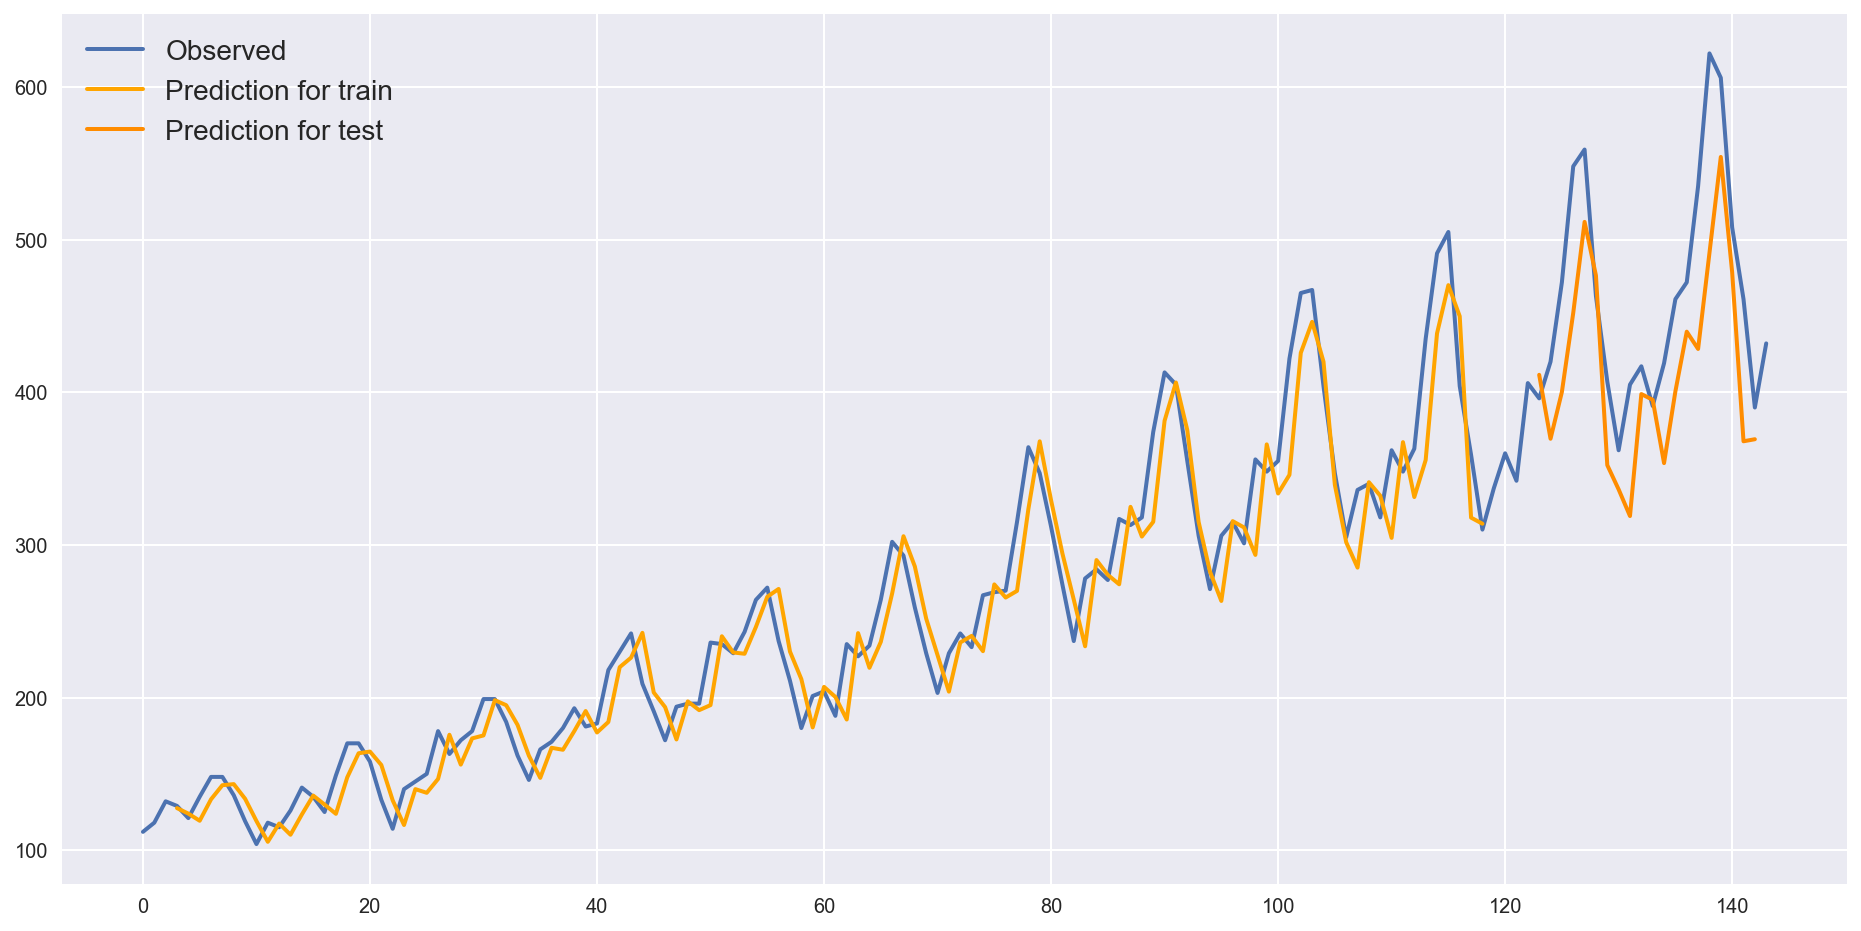

In [58]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict

# plot observation and predictions
plt.plot(data, label='Observed');
plt.plot(train_predict_plot, label='Prediction for train', color='orange');
plt.plot(test_predict_plot, label='Prediction for test', color='darkorange');
plt.legend(loc='best');
plt.show()

In [59]:
mse = ((y_test - test_predict) ** 2).mean()
print(mse)
print(math.sqrt(mse))

11647.3222988
107.92276080044431
